# Environment setup

## Download code and data


In [2]:
!pip install imagecodecs tifffile torchgeometry

     |████████████████████████████████| 17.9MB 215kB/s 
     |████████████████████████████████| 51kB 8.9MB/s 


In [3]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 183 (delta 100), reused 81 (delta 34), pack-reused 0
Receiving objects: 100% (183/183), 1.75 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/ml-segmentation-project


In [4]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  7654k      0  0:00:09  0:00:09 --:--:-- 14.5M


## Useful imports and settings

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import os,sys
import pandas as pd
import time
import torch
import torchgeometry as tgm
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import unet
from dataset import CellSegmentationDataset, PadToSize


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [6]:
BATCH_SIZE = 2
TRAIN_PERCENT = 0.8
CLASS_NUMBER = 3
IMG_SIZE = 1024

img_transform = transforms.Compose([
    # Convert to 0-1 float
    transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.astype(np.float32)),
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_binary_transform = transforms.Compose([
    target_transform,
    # Limit to 0-1 for foreground-background segmentation
    transforms.Lambda(lambda img: img.clamp(max=1.0)),
])

target_boundary_transform = transforms.Compose([
    target_transform,
    transforms.Lambda(lambda img: img.clamp(max=1.0)),
    transforms.Lambda(lambda img: img + binary_dilation(img)),
    transforms.Lambda(lambda img: img.long().squeeze()),
])

target_transform = target_boundary_transform if CLASS_NUMBER > 2 else target_binary_transform

full_dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="Neuroblastoma",
                                  transform=img_transform,
                                  target_transform=target_transform
                                )

train_size = int(len(full_dataset) * TRAIN_PERCENT)
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Training

In [7]:
model = unet.UNet(num_classes=CLASS_NUMBER).to(device)
summary(model, input_size=(1, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]             640
              ReLU-2       [-1, 64, 1024, 1024]               0
            Conv2d-3       [-1, 64, 1024, 1024]          36,928
              ReLU-4       [-1, 64, 1024, 1024]               0
         MaxPool2d-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 512, 512]          73,856
              ReLU-7        [-1, 128, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]         147,584
              ReLU-9        [-1, 128, 512, 512]               0
        MaxPool2d-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 256, 256]         295,168
             ReLU-12        [-1, 256, 256, 256]               0
           Conv2d-13        [-1, 256, 256, 256]         590,080
             ReLU-14        [-1, 256, 2

We first define the evaluation functions we'll be using during training.

In [8]:
def evaluate(model, loader, criterion):
    n_val = len(loader)
    tot = 0
    with torch.no_grad():
        for image, labels in loader:
            pred = model(image.to(device))
            tot += criterion(pred, labels.to(device))
    return tot / n_val

In [9]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Training phase
        model.train()

        epoch_loss = 0
        epoch_samples = len(train_loader)
            
        torch.cuda.empty_cache()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            epoch_loss += loss.item()

        #scheduler.step()
        
        print("Epoch train loss: {}".format(epoch_loss / epoch_samples))
        # print("Epoch dice loss: {}".format(epoch_dice_loss / epoch_samples))

        # Evaluation phase
        model.eval()
        val_loss = evaluate(model, val_loader, criterion)
        if val_loss < best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())

        print("Epoch validation loss: {}".format(val_loss))

        time_elapsed = time.time() - since
        print('Took {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model

In [10]:
def combined_loss(criterion1, criterion2, mix=.5):
    def loss(output, labels):
        return mix * criterion1(output, labels) + (1 - mix) * criterion2(output, labels)
    
    return loss


# TGM's dice loss wants labels to be of the shape [N, H, W], whereas
# BCE wants them as [N, C, H, W]. This is an adapter that receives vector
# in the latter form and computes dice loss converting them to the former.
def dice_loss(output, labels):
    return tgm.losses.dice_loss(output, labels.squeeze().long())

In [11]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99

torch.cuda.empty_cache()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if CLASS_NUMBER > 2:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()

# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
model = train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: 1.8457142199788774
Epoch validation loss: 0.8910026550292969
Took 0m 13s

Epoch 2/20
----------
Epoch train loss: 0.9286684393882751
Epoch validation loss: 0.8796912431716919
Took 0m 13s

Epoch 3/20
----------
Epoch train loss: 0.8699002180780683
Epoch validation loss: 0.7582725286483765
Took 0m 14s

Epoch 4/20
----------
Epoch train loss: 0.7245856438364301
Epoch validation loss: 0.5706530809402466
Took 0m 14s

Epoch 5/20
----------
Epoch train loss: 0.4582770807402475
Epoch validation loss: 0.23570525646209717
Took 0m 14s

Epoch 6/20
----------
Epoch train loss: 0.244133965245315
Epoch validation loss: 0.1839982271194458
Took 0m 14s

Epoch 7/20
----------
Epoch train loss: 0.21918322145938873
Epoch validation loss: 0.1844736635684967
Took 0m 14s

Epoch 8/20
----------
Epoch train loss: 0.19541775754519872
Epoch validation loss: 0.14518266916275024
Took 0m 14s

Epoch 9/20
----------
Epoch train loss: 0.17961020448378154
Epoch validation loss: 0.

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [27]:
def show_results(inputs, labels, outputs):
    plt.gray()
    count = len(inputs)
    fig = plt.figure(figsize=(6 * 3, 6 * count))
    axs = fig.subplots(count, 3)
    
    for ax in axs.flat:
        ax.axis("off")
    
    column_labels = ["Input image", "Ground truth", "Generated prediction"]

    if count == 1:
        for ax, label in zip(axs, column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[0].imshow(inputs[i].squeeze())
            axs[1].imshow(labels[i].squeeze())
            axs[2].imshow(outputs[i].squeeze())
    else:
        for ax, label in zip(axs[0], column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[i, 0].imshow(inputs[i].squeeze())
            axs[i, 1].imshow(labels[i].squeeze())
            axs[i, 2].imshow(outputs[i].squeeze())
    
    fig.show()

def show_image(image):
    plt.imshow(image.squeeze())

<Figure size 432x288 with 0 Axes>

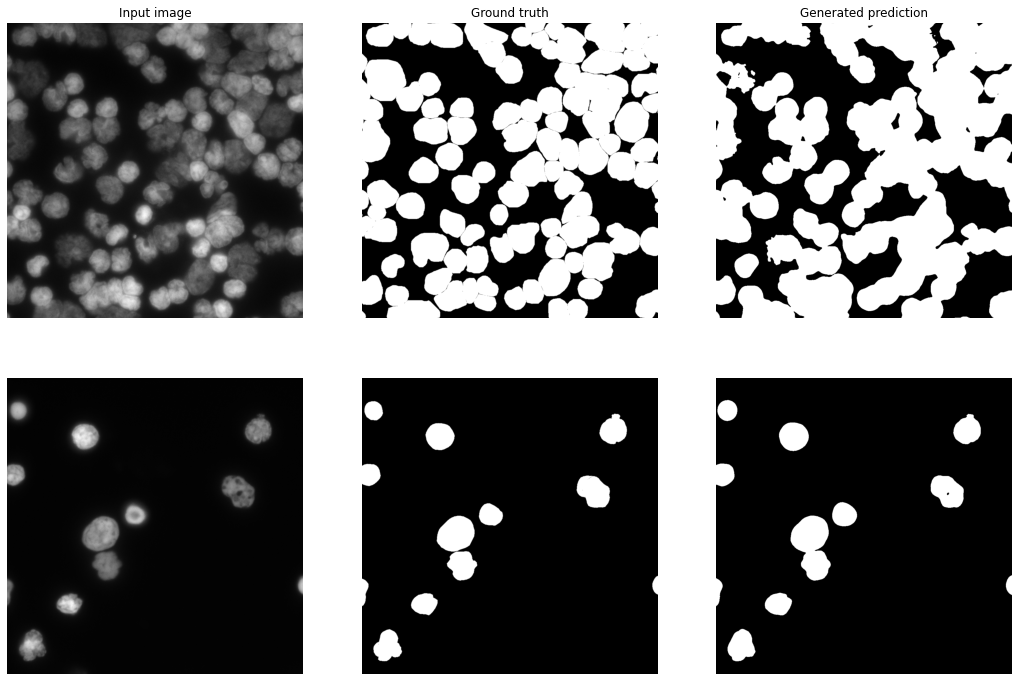

In [17]:
inputs, labels = next(iter(val_loader))
outputs = model.predict(inputs.to(device))

output_np = outputs.numpy()
output_squeeze = np.where(output_np[:,0,:,:],0,np.nan)
for i in range(1, output_np.shape[1]):
  output_squeeze = np.where(output_np[:,i,:,:],i,output_squeeze)


show_results(inputs, labels, output_squeeze)

<Figure size 432x288 with 0 Axes>

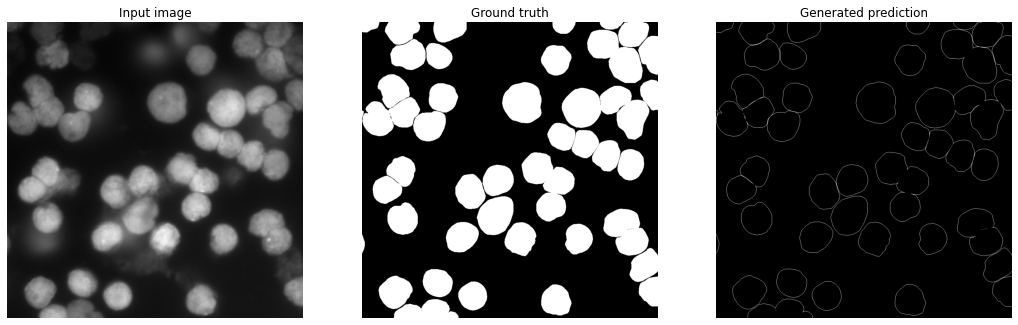

In [ ]:
show_results(inputs[:1], labels[:1], [(binary_dilation(labels[0]) - labels[0].numpy())])

In [178]:
def label_with_watershed(image, min_distance=50):
  """
    Inputs
      image: Image to be labelled
      min_distance: Minimum distance that cell-centers should be apart of eachother in
                    pixels
    Outputs:
      Labelled image with every cell having a different value (v > 0) and a border
      between every cell (1-pixel wide)
  """
  # Euclidean distance matrix of the image
  distance = ndi.distance_transform_edt(image)
  # List of (x,y) pairs representing the coordinates of the peaks
  coords_of_peaks = peak_local_max(distance, min_distance=min_distance, footprint=np.ones((64,64)), labels=image)
  # Black image with white pixels representing the peaks (cell-centers)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords_of_peaks.T)] = True
  # Mask transformed to having a different value per peak (cell-center)
  markers, _ = ndi.label(mask)

  # Return the watershed labels, use -distance because watershed works on minima.
  return watershed(-distance, markers, mask=image, watershed_line=True)

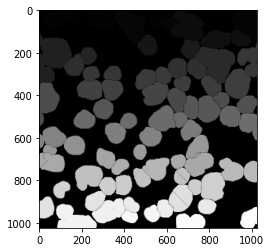

In [179]:
# Example:
show_image(label_with_watershed(labels[0].numpy()))

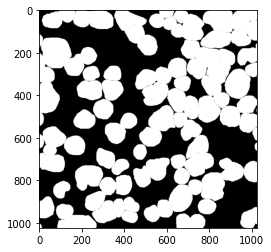

In [180]:
show_image(labels[0].numpy())


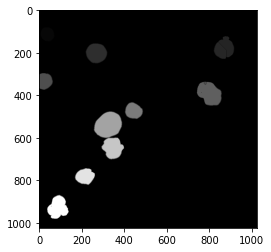

In [181]:
show_image(label_with_watershed(labels[1].numpy()))

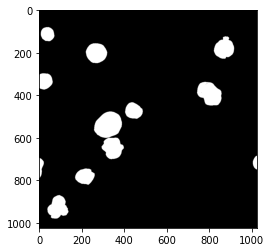

In [182]:
show_image(labels[1].numpy())
